In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc("pdf", fonttype=42)

from geoscripts.dz import dz

In [2]:
hf_directory = "~/Box/UC Davis/Laserchron/Vasey Hf 2019/"
samples = ['100311-3A','C17069B','V17043A']

paths = [hf_directory+sample+'.csv' for sample in samples]

data = [pd.read_csv(path) for path in paths]

smps = []
for k,df in enumerate(data):
    smp = dz.DZSample(name=samples[k],agedata=df,source='Vasey22')
    smp.calc_bestage(col_238='Age',col_207='Age')
    smps.append(smp)

['GE0011', 'GE0345']
GE0011
Propagating systematic error -  0.7 
Original error:  3.5956427129252213
GE0345
Propagating systematic error -  0.7 
Original error:  2.7284299293346046


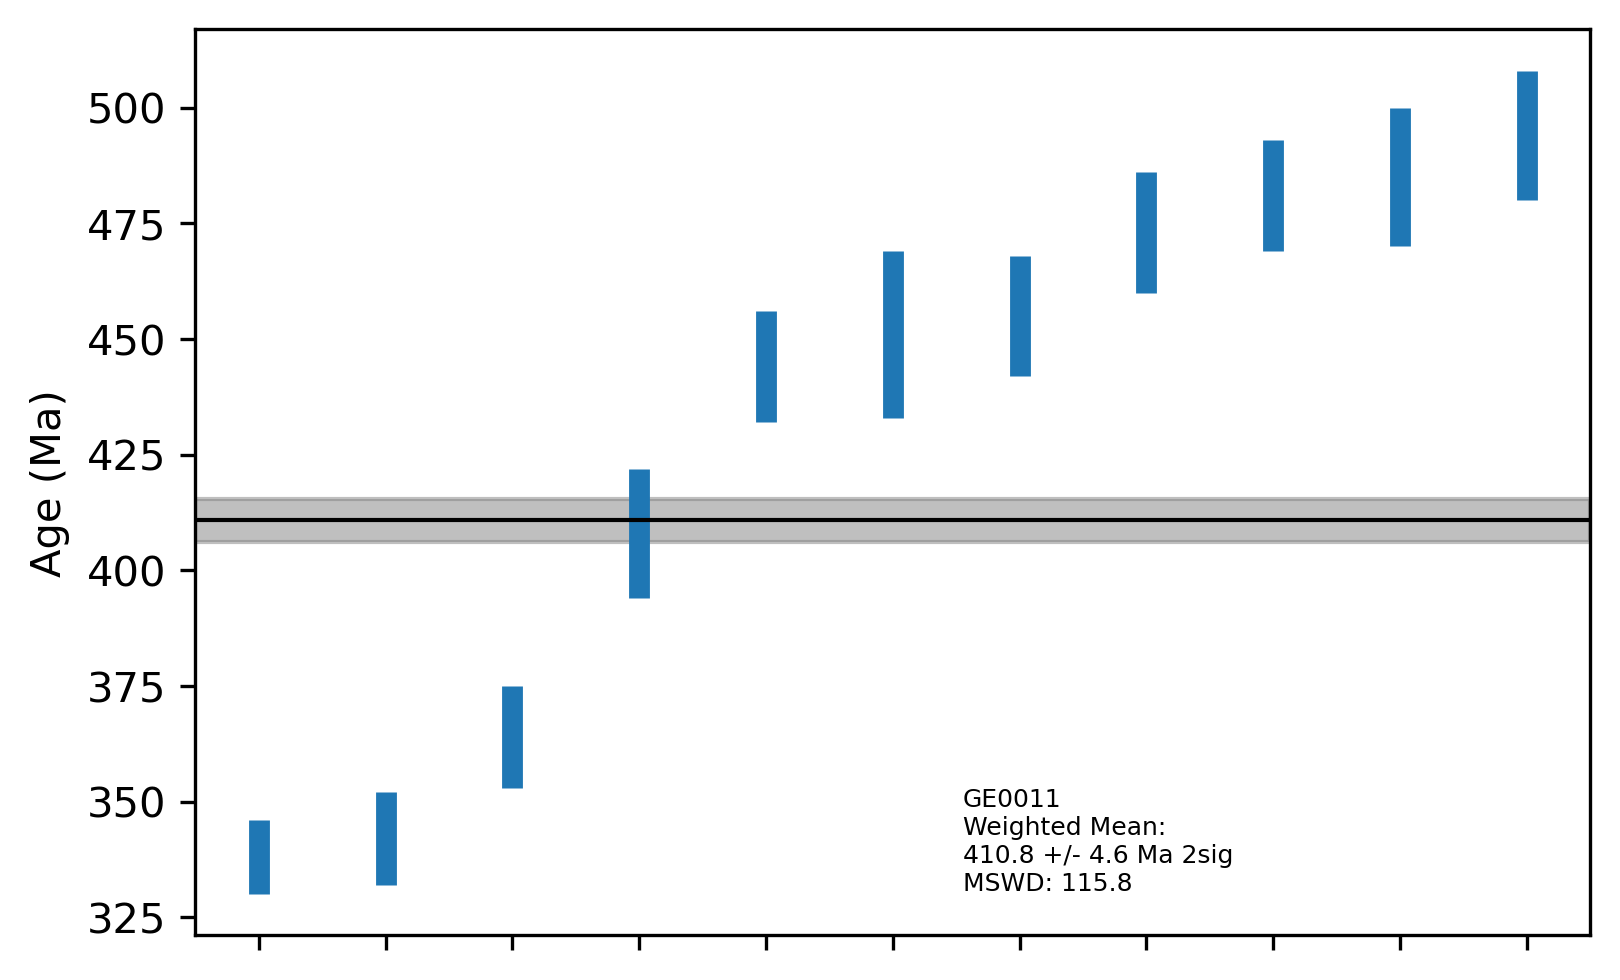

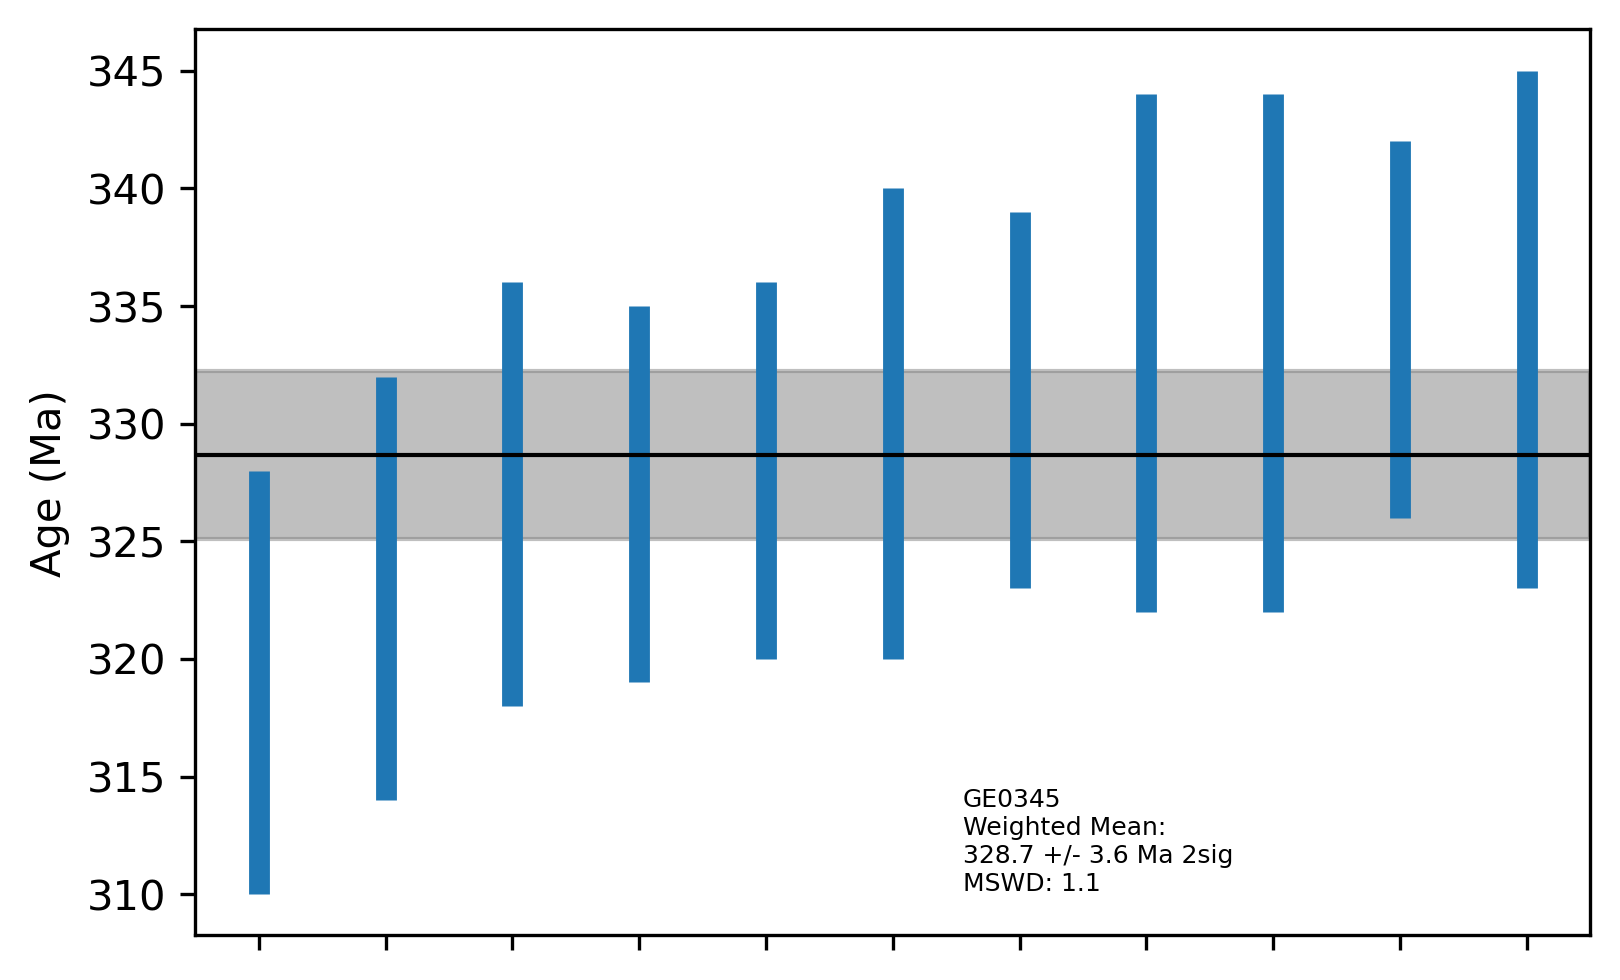

In [3]:
mayringer_directory = "~/Box/UC Davis/Manuscripts/CaucasusDZ/PublishedRawData/Mayringer11.csv"

mayringer_raw = pd.read_csv(mayringer_directory)

# Assume age data for spot 14.2 is equal to spot 14.1 for 345
age_cols = ['238Age','238sig2','207Age','207sig2']

mayringer_raw.loc[45,age_cols] = mayringer_raw.loc[43,age_cols]

names = list(mayringer_raw['Sample'].unique())
print(names)

msamples = []

for name in names:
    smp_boolean = mayringer_raw.loc[:,'Sample']==name
    data = mayringer_raw.loc[smp_boolean]
    
    sample = dz.DZSample(name=name,agedata=data,source='Mayringer11')
    print(sample.name)
    
    sample.calc_bestage(col_238='238Age',col_207='207Age',
                        err_238='238sig2',err_207='207sig2',err_lev='2sig',
                        filter_disc=False,use_err=True)
    
    young_pop = smp.bestage[(smp.bestage<350)].count()
    
    sample.syst_238 = 0.7

    sample.calc_mda(method='manual',grains=np.arange(1,young_pop,1),systematic=True)

    msamples.append(sample)

C:\Users\dyvas\AppData\Local\Temp\ipykernel_20100\2251013787.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages.loc[:,'±.6'] = ages.loc[:,'±.6']*2
C:\Users\dyvas\AppData\Local\Temp\ipykernel_20100\2251013787.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages.loc[:,'±.6'] = ages.loc[:,'±.6']*2
C:\Users\dyvas\AppData\Local\Temp\ipykernel_20100\2251013787.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

33
Propagating systematic error -  1.063742485 
Original error:  0.3392414200709999
Using overdispersion factor, original error:  1.835849613068053
0     162.995184
1     164.115046
2     165.708283
3     165.887045
4     166.221303
5     166.873297
6     167.091185
7      167.99635
8     168.107053
9     168.916147
10    169.240489
11    169.264984
12    169.277744
13    169.554843
14    169.614587
15     169.92709
16    169.995359
17    170.055556
18    170.220393
19    170.938195
20    171.139767
21    171.425151
22    171.516274
23    171.609802
24    171.841061
25    172.178313
26    172.293413
27    172.334078
28    172.563834
29    172.715025
30    172.790331
31    173.631648
32    174.706443
Name: Best Age, dtype: object 0     1.765023
1     1.662873
2     2.273954
3     1.972911
4     1.918348
5     1.713296
6     2.149072
7     1.964007
8     1.990524
9     2.066105
10    2.127769
11    1.865901
12    2.187463
13    1.951614
14    1.745407
15    2.023918
16    1.594467
17    

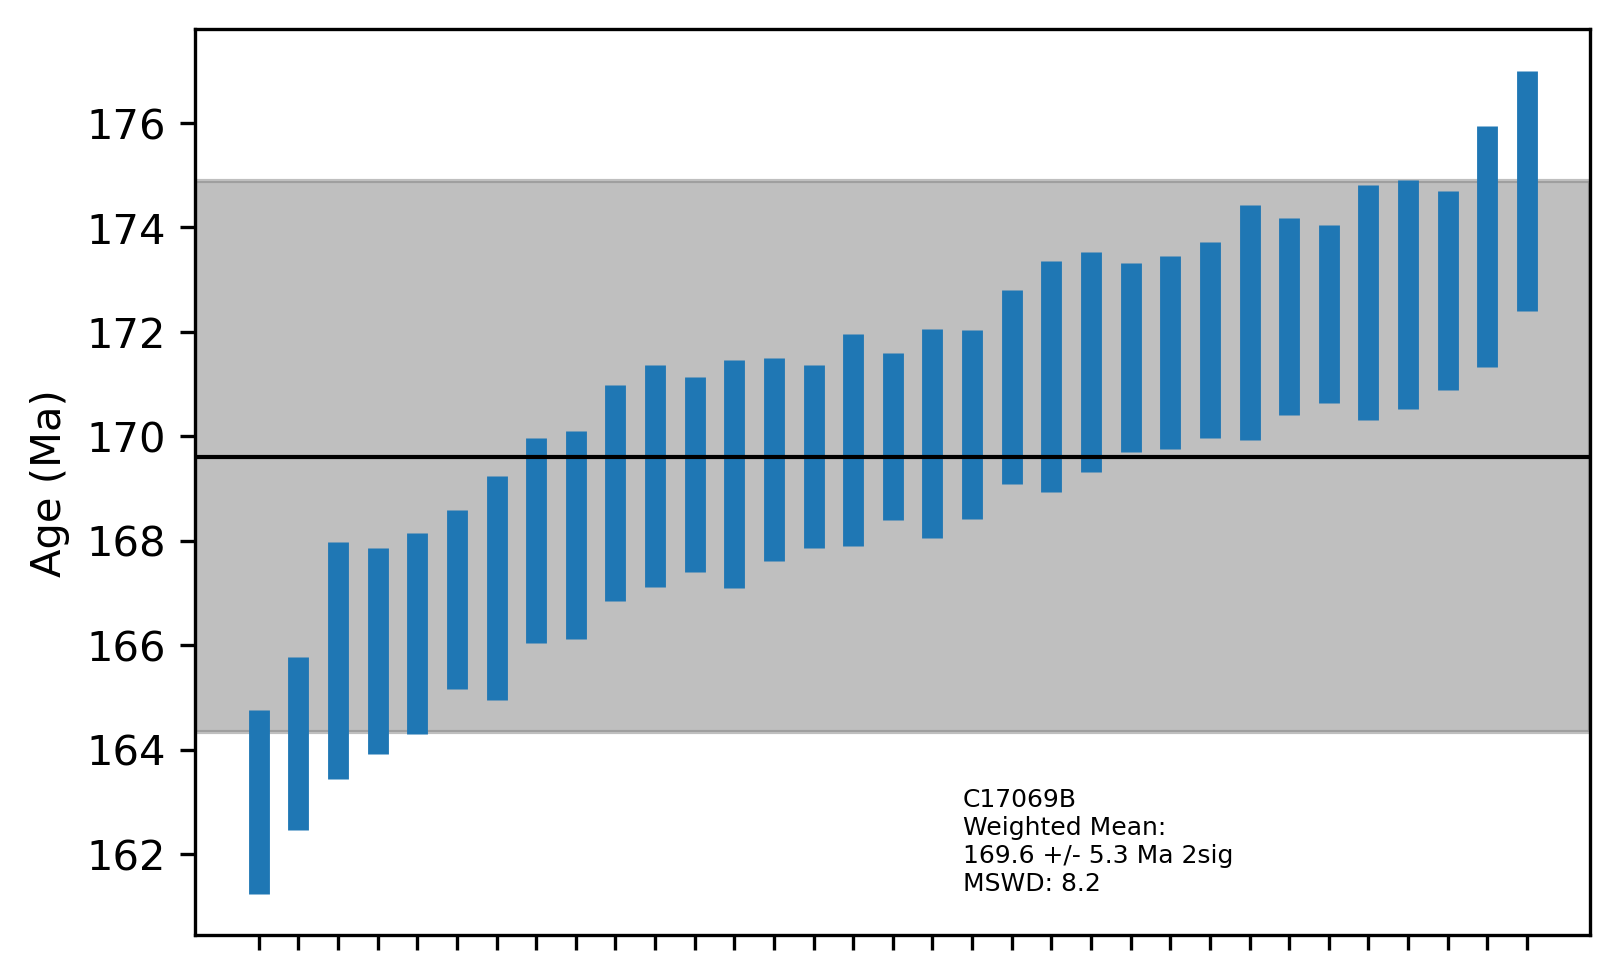

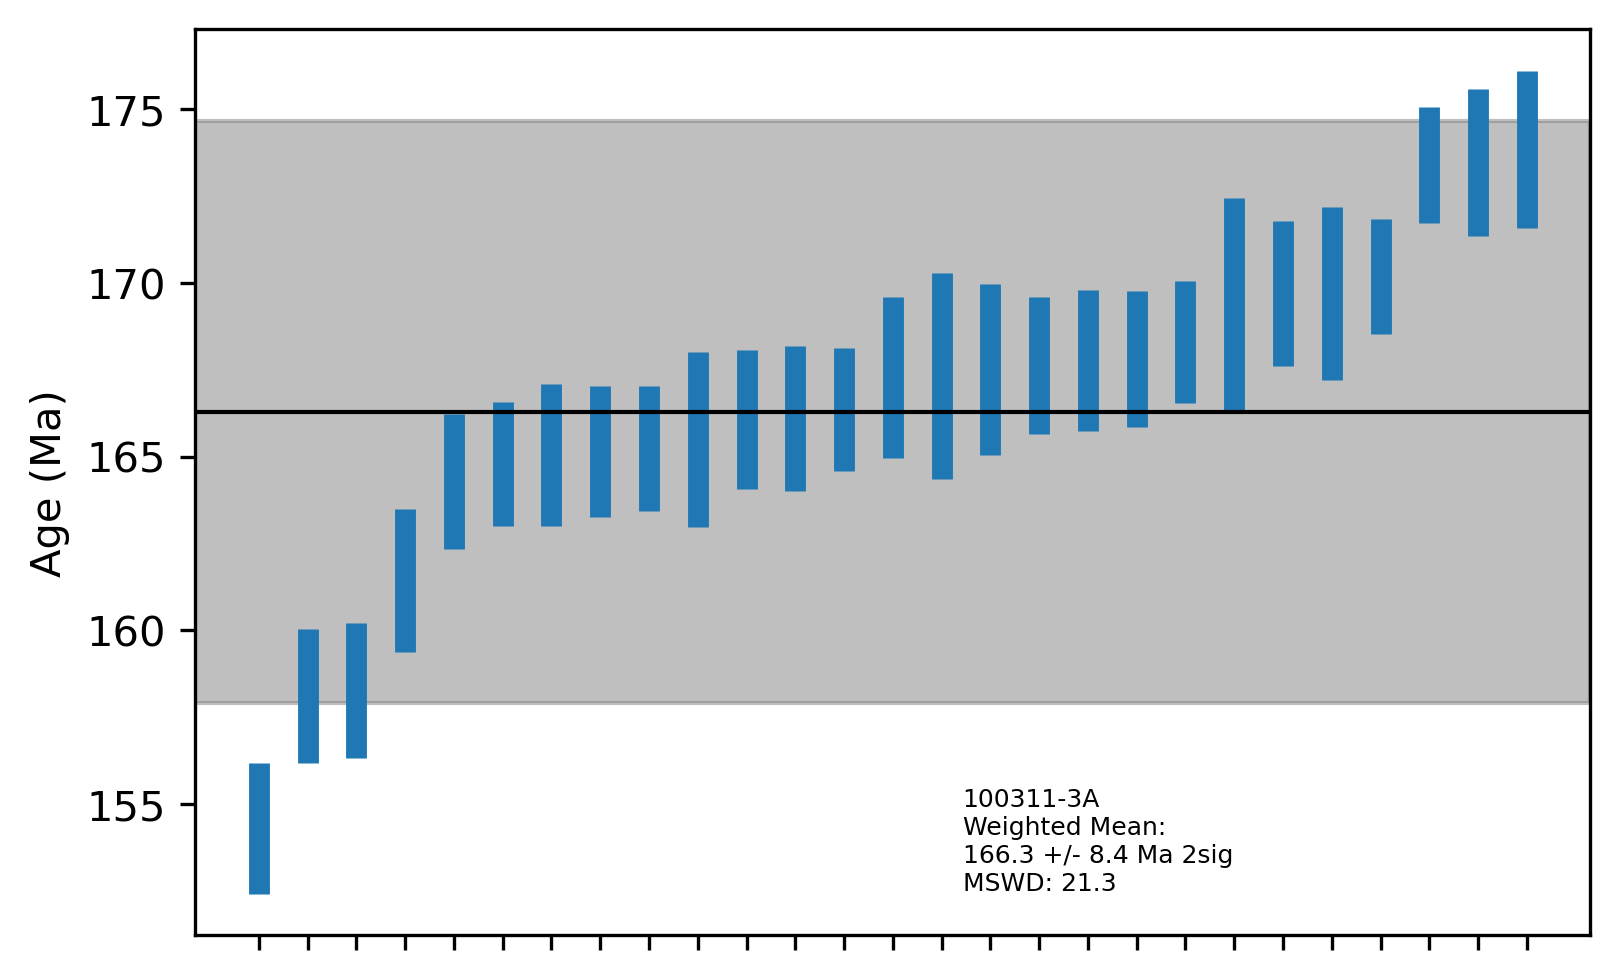

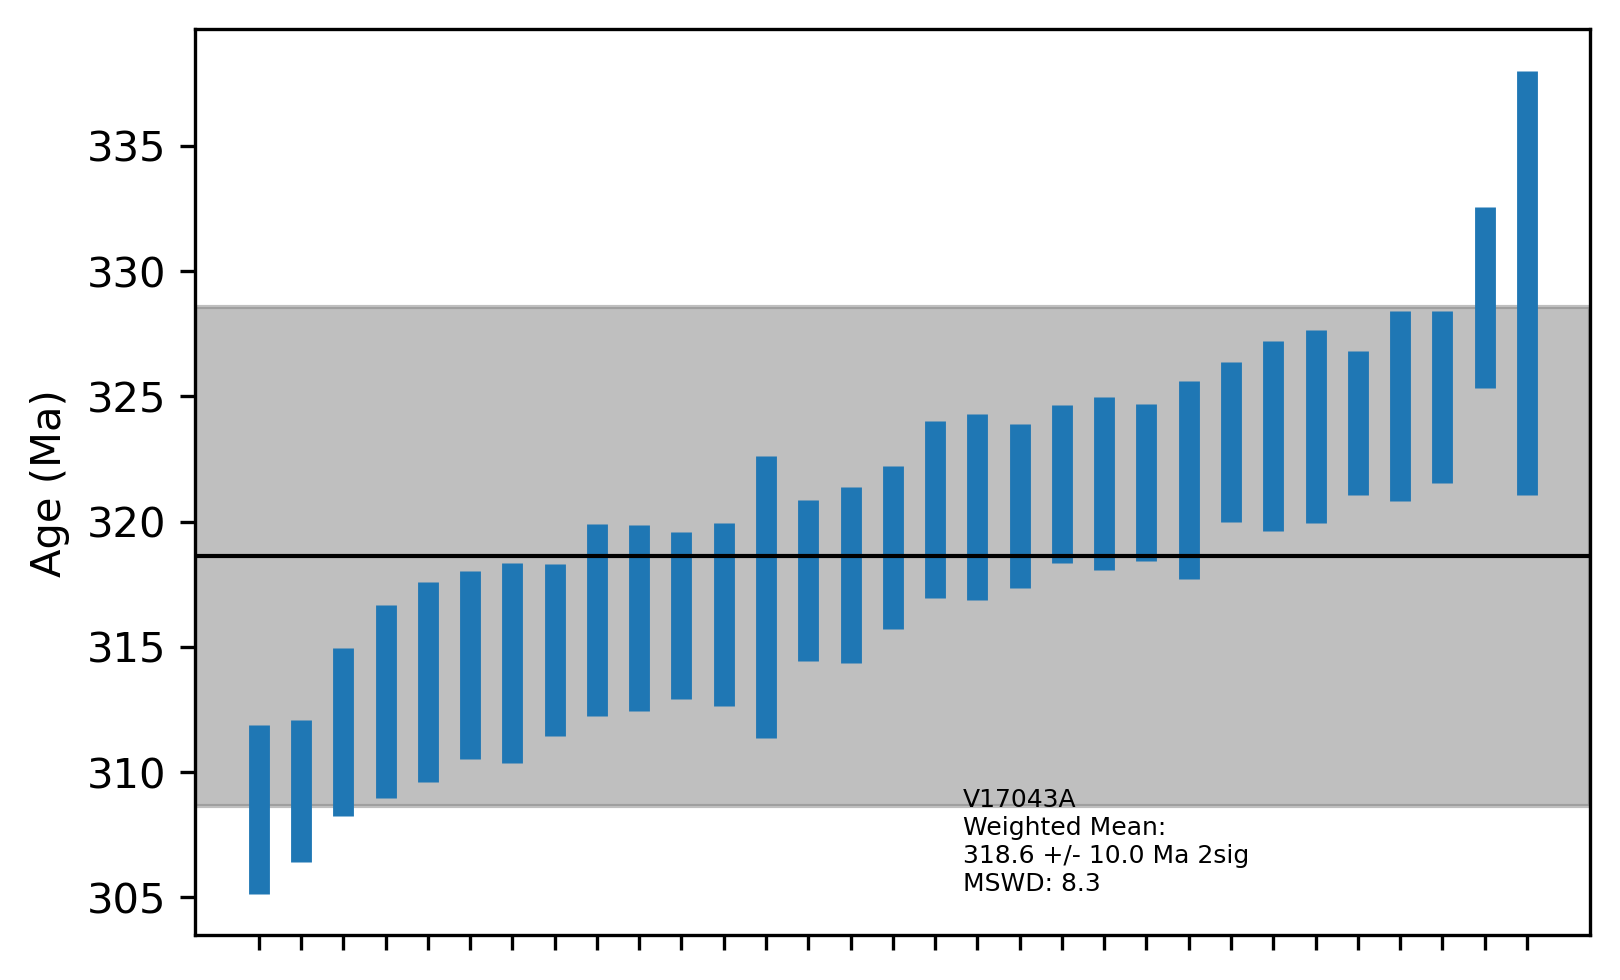

In [4]:
# Get crystallization ages for new samples

dat_path = "~/Box/UC Davis/Laserchron/Vasey UPb 9-19/Vasey_Upb9-19_datatable.xls"
data = pd.read_excel(dat_path,skiprows=22)

age_columns = ['Analysis','Best age','±.6']
agedata = data[age_columns].dropna(how='any')
#print(agedata)

age_cutoffs = [190,190,330]

syst_238 = 1.063742485

ig_upb = []
samples=['C17069B','100311-3A','V17043A']
for k,name in enumerate(samples):
    ages = agedata[agedata.Analysis.str.contains(name)]
    ages.loc[:,'±.6'] = ages.loc[:,'±.6']*2
    smp = dz.DZSample(name=name,agedata=ages)
    smp.calc_bestage(col_238='Best age',col_207='Best age',err_238='±.6',err_207='±.6',err_lev='2sig',
                        filter_disc=False,use_err=True)
    
    young_pop = smp.bestage[smp.bestage<age_cutoffs[k]].count()
    print(young_pop)

    smp.syst_238 = syst_238

    mda = smp.calc_mda(method='manual',grains=np.arange(0,young_pop,1),overdisperse=True,systematic=True)
    ig_upb.append(smp)

    print(mda[2],mda[3])


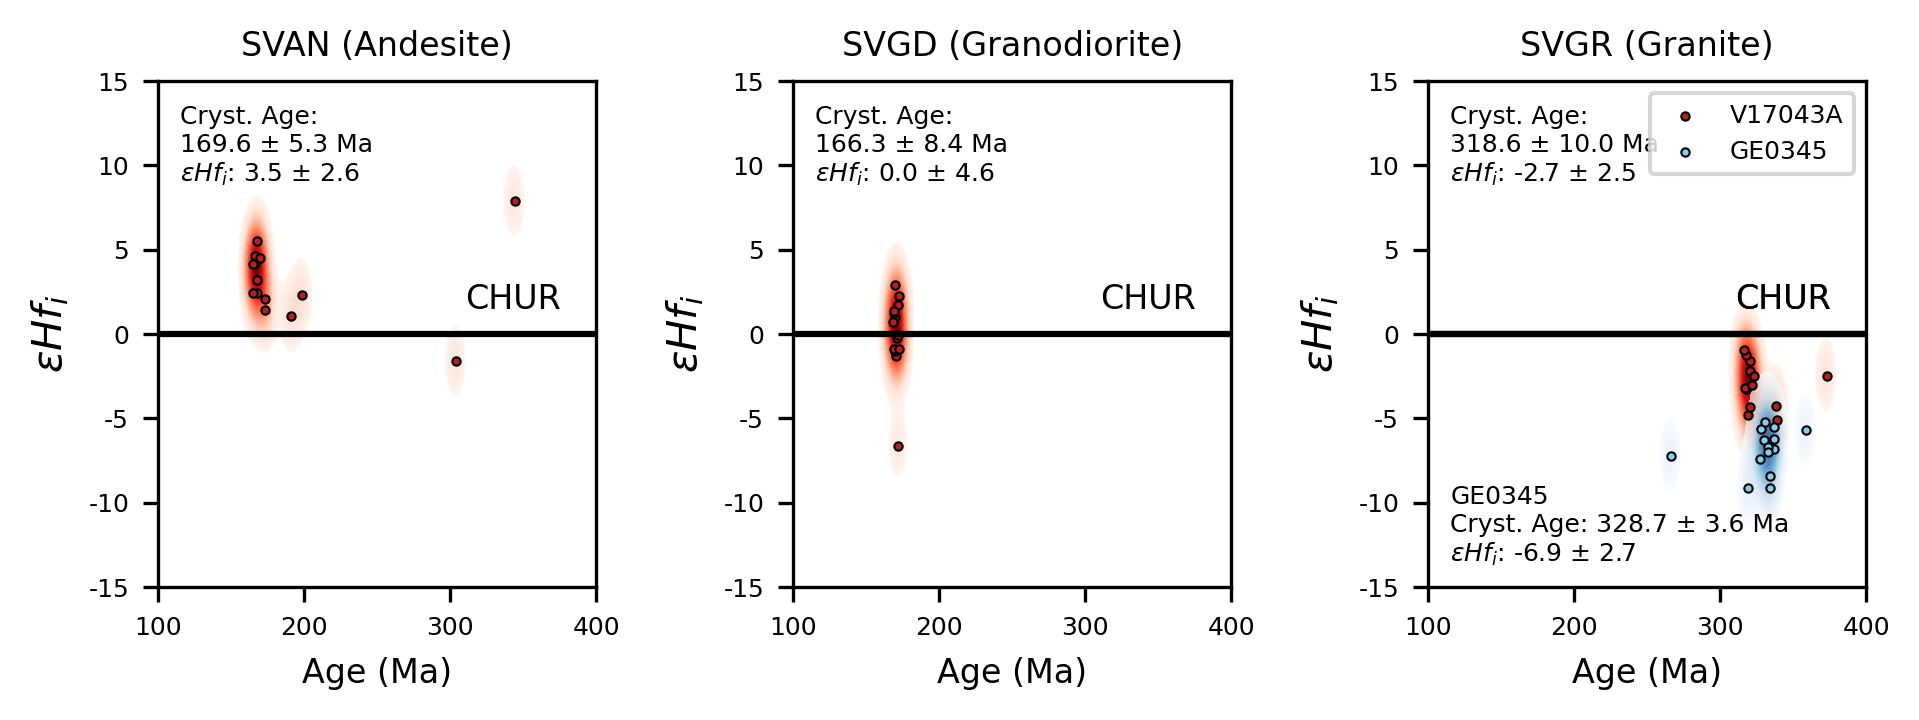

In [5]:
fig,axs = plt.subplots(1,3,dpi=300,figsize=(6.5,2.5))

age_cutoffs = [190,190,330]
title_text = ['SVAN (Andesite)','SVGD (Granodiorite)','SVGR (Granite)']

for k,smp in enumerate(smps):
    smp.kde_hf('Ehf',method=[5,1.5],cmap='Reds',xlim=(100,400),ylim=(-15,15),ax=axs.flat[k],vmin=0.05,include_ages=True,
    marker_color='firebrick',alpha=1)
    axs.flat[k].xaxis.label.set_size(8)
    axs.flat[k].xaxis.label.set_size(8)
    axs.flat[k].set_xticks([100,200,300,400])
    axs.flat[k].set_yticks(np.arange(-15,16,5))
    axs.flat[k].set_xticklabels([100,200,300,400],fontsize=6)
    axs.flat[k].set_yticklabels(np.arange(-15,16,5),fontsize=6)
    axs.flat[k].set_title(title_text[k],fontsize=8)

    age,err = ig_upb[k].mda,ig_upb[k].mda_err

    hf_young = smp.agedata[smp.agedata['Age']<age_cutoffs[k]]

    mean_hf = np.mean(hf_young['Ehf'])
    hf2sig = hf_young['Ehf'].std()*2
    
    hf_text = (
        'Cryst. Age:\n' + str(round(age,1)) + ' ± ' +  str(round(err,1)) +
        ' Ma\n$\epsilon Hf_i$: ' + str(round(mean_hf,1)) + ' ± ' + str(round(hf2sig,1))
    )
    axs.flat[k].text(0.05,0.8,hf_text,transform=axs.flat[k].transAxes,fontsize=6)

for smp in [msamples[1]]:
    hf_young = smp.agedata[(smp.agedata['238Age']<350)&(smp.agedata['238Age']>300)]

    mean_hf = np.mean(hf_young['epsHfinit_rep'])
    hf2sig = hf_young['epsHfinit_rep'].std()*2
    hf_text = (
        'GE0345\nCryst. Age: ' + str(round(smp.mda,1)) + ' ± ' +  str(round(smp.mda_err,1)) + 
        ' Ma\n$\epsilon Hf_i$: ' + str(round(mean_hf,1)) + ' ± ' + str(round(hf2sig,1))
    )
    axs.flat[2].text(0.05,0.05,hf_text,transform=axs.flat[k].transAxes,fontsize=6)

    smp.kde_hf('epsHfinit_rep',method=[5,1.5],cmap='Blues',xlim=(100,400),ylim=(-15,15),ax=axs.flat[2],vmin=0.05,include_ages=True,
    marker_color='skyblue',alpha=0.7)


axs.flat[2].legend(fontsize=6)


plt.tight_layout()
fig.savefig('hf.pdf')


In [6]:
for smp in smps:
    print(smp.name,smp.latlon)

100311-3A None
C17069B None
V17043A None


In [7]:
from scipy.stats import gaussian_kde

In [8]:
ages = smps[0].bestage
hf = smps[0].agedata['Ehf']

print(ages,hf)

ages_kde = gaussian_kde(ages)
hf_kde = gaussian_kde(hf)

xgrid = np.linspace(0,500,100)
ygrid = np.linspace(-20,15,100)

ages_density = ages_kde(xgrid)
hf_density = hf_kde(ygrid)

0     166.4
1     167.3
2     166.1
3     173.4
4     166.1
5     167.3
6     167.8
7     165.2
8     173.4
9     165.0
10    169.7
11    190.6
12    198.2
13    304.0
14    344.5
15    797.2
Name: Best Age, dtype: float64 0     4.237391
1     2.414891
2     4.212537
3     1.436581
4     4.607301
5     3.223212
6     5.527067
7     4.174203
8     2.070759
9     2.454567
10    4.495866
11    1.067269
12    2.325498
13   -1.610693
14    7.907638
15   -8.784322
Name: Ehf, dtype: float64


In [9]:
import statsmodels.api as sm

In [10]:
sdata = np.vstack([ages,hf]).T
print(sdata.shape)
print(sdata)

print(np.diag([4,2]))

dens_u = sm.nonparametric.KDEMultivariate(data=sdata, var_type='cc', bw=[4,2])


(16, 2)
[[166.4          4.23739103]
 [167.3          2.41489093]
 [166.1          4.21253746]
 [173.4          1.43658138]
 [166.1          4.60730095]
 [167.3          3.22321216]
 [167.8          5.52706692]
 [165.2          4.17420302]
 [173.4          2.07075896]
 [165.           2.45456738]
 [169.7          4.49586649]
 [190.6          1.06726941]
 [198.2          2.32549836]
 [304.          -1.61069254]
 [344.5          7.90763783]
 [797.2         -8.78432234]]
[[4 0]
 [0 2]]


In [11]:
xx,yy = np.meshgrid(xgrid,ygrid)

print(xx)
print(yy)

grid_coords = np.append(xx.reshape(-1,1), yy.reshape(-1,1),axis=1)

print(grid_coords.shape)

z = dens_u.pdf(grid_coords)

print(z.shape)

z = z.reshape(len(ygrid), len(xgrid))

print(z)

[[  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]
 [  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]
 [  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]
 ...
 [  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]
 [  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]
 [  0.           5.05050505  10.1010101  ... 489.8989899  494.94949495
  500.        ]]
[[-20.         -20.         -20.         ... -20.         -20.
  -20.        ]
 [-19.64646465 -19.64646465 -19.64646465 ... -19.64646465 -19.64646465
  -19.64646465]
 [-19.29292929 -19.29292929 -19.29292929 ... -19.29292929 -19.29292929
  -19.29292929]
 ...
 [ 14.29292929  14.29292929  14.29292929 ...  14.29292929  14.29292929
   14.29292929]
 [ 14.64646465  14.64646465  14.64646465 ...  14.64646465  14.64646465
   14.64646465]
 [ 15.          15.          15.        

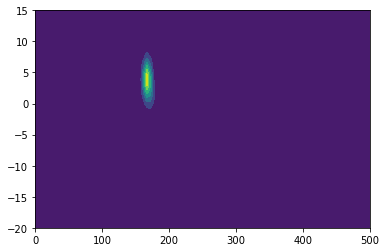

In [12]:
plt.contourf(xgrid,ygrid,z)

C17069B 169.6118820661657
100311-3A 166.28428213409595
V17043A 318.61056190730113
GE0345 328.68522242413536


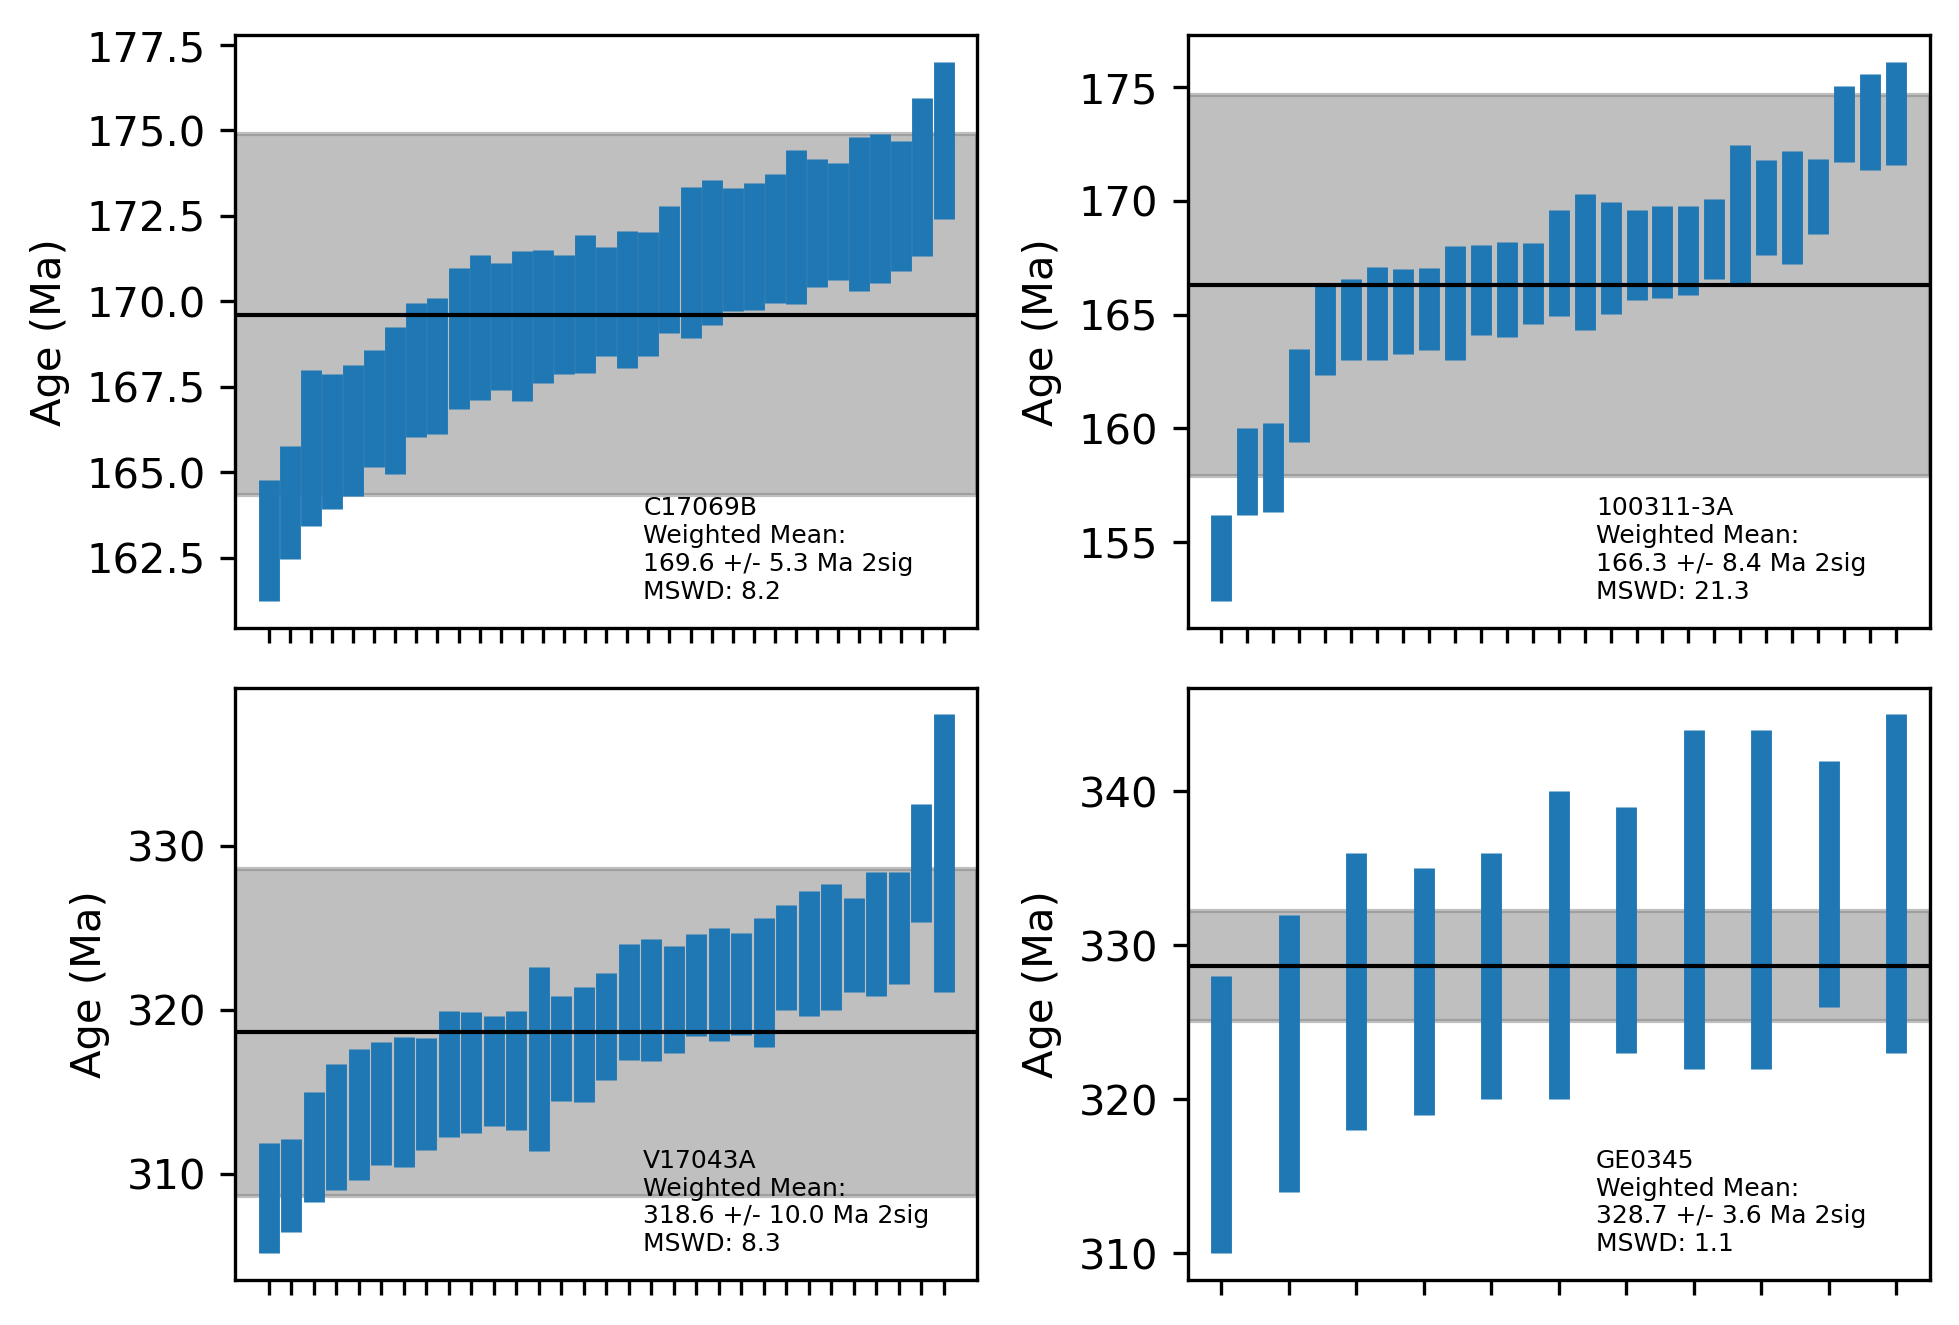

In [13]:
samples = ig_upb + [msamples[1]]

fig, axs = plt.subplots(2,2,dpi=300,figsize=(6.5,4.5))

for k,smp in enumerate(samples):
    print(smp.name,smp.mda)
    smp.plot_mda(axs.flat[k])

plt.tight_layout()

fig.savefig('cryst_ages.pdf')